In [8]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

Epoch 1/20
6/6 [==============================] - 1s 77ms/step - loss: 6.6961 - accuracy: 0.5976 - val_loss: 1.5777 - val_accuracy: 0.5814
Epoch 2/20
6/6 [==============================] - 0s 40ms/step - loss: 0.9259 - accuracy: 0.7396 - val_loss: 0.2724 - val_accuracy: 0.8140
Epoch 3/20
6/6 [==============================] - 0s 35ms/step - loss: 0.1634 - accuracy: 0.9349 - val_loss: 0.1744 - val_accuracy: 0.9535
Epoch 4/20
6/6 [==============================] - 0s 38ms/step - loss: 0.0772 - accuracy: 0.9882 - val_loss: 0.1433 - val_accuracy: 0.9535
Epoch 5/20
6/6 [==============================] - 0s 35ms/step - loss: 0.0838 - accuracy: 0.9704 - val_loss: 0.1175 - val_accuracy: 0.9535
Epoch 6/20
6/6 [==============================] - 0s 34ms/step - loss: 0.0355 - accuracy: 0.9882 - val_loss: 0.1235 - val_accuracy: 0.9535
Epoch 7/20
6/6 [==============================] - 0s 35ms/step - loss: 0.0421 - accuracy: 0.9882 - val_loss: 0.1074 - val_accuracy: 0.9767
Epoch 8/20
6/6 [===========

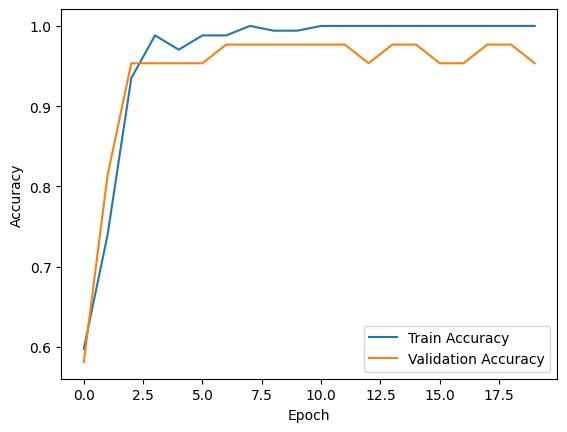

In [10]:
# 데이터 경로 설정
split_car_folder = "C:\\3-2\\p\\soundDetection\\data\\splitCar"
split_no_car_folder = "C:\\3-2\\p\\soundDetection\\data\\splitNoCar"

# 오디오 데이터를 읽고 특징 추출 (MFCC)
def extract_features(file_path, max_pad_len=44, target_sample_rate=16000):
    # 오디오 데이터를 16kHz로 리샘플링
    audio, sample_rate = librosa.load(file_path, sr=target_sample_rate, res_type='kaiser_fast')
    # MFCC 추출
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    # 패딩 또는 자르기
    pad_width = max_pad_len - mfcc.shape[1]
    if pad_width > 0:
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfcc = mfcc[:, :max_pad_len]
    return mfcc

# 데이터 준비
def prepare_dataset(car_folder, no_car_folder, target_sample_rate=16000):
    data = []
    labels = []
    # 자동차 소리 데이터
    for file_name in os.listdir(car_folder):
        if file_name.endswith('.wav'):
            file_path = os.path.join(car_folder, file_name)
            features = extract_features(file_path, target_sample_rate=target_sample_rate)
            data.append(features)
            labels.append('car')

    # 비자동차 소리 데이터
    for file_name in os.listdir(no_car_folder):
        if file_name.endswith('.wav'):
            file_path = os.path.join(no_car_folder, file_name)
            features = extract_features(file_path, target_sample_rate=target_sample_rate)
            data.append(features)
            labels.append('no_car')

    return np.array(data), np.array(labels)

# 데이터 로드 및 전처리
X, y = prepare_dataset(split_car_folder, split_no_car_folder, target_sample_rate=16000)
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 'car' -> 0, 'no_car' -> 1
X = X[..., np.newaxis]  # CNN 입력 형태로 변경

# 학습 및 검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# CNN 모델 설계
def create_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # 이진 분류
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 모델 생성 및 학습
input_shape = X_train.shape[1:]
model = create_model(input_shape)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# 성능 평가
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# 학습 결과 시각화
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# 모델 저장
model.save("car_detection_cnn_model_16kHz.h5")